# start

In [1]:
SEED = 104

In [2]:
PRFX = f'RndMdl0814_2_seed{SEED}'

In [3]:
p_o = f'../output/{PRFX}'

# p_o = f'.'

from pathlib import Path
Path(p_o).mkdir(exist_ok=True, parents=True)


In [4]:
dbg = False
if dbg: dbgsz=500

from fastai.vision import * 

In [5]:
!nvidia-smi

Thu Aug 15 03:43:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    43W / 300W |     10MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
# Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b3-c8376fa2.pth
import os
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')

!cp ../input/efficientnetpytorch/*.pth /tmp/.cache/torch/checkpoints/

# params

In [7]:
BS = 16
FP16 = True
PERC_VAL = 0.1
WD = 0.01


MODEL_NAME = 'efficientnet-b5'
from efficientnet_pytorch import EfficientNet
SZ = EfficientNet.get_image_size(MODEL_NAME)
for i in range(6):
    print(f'efficientnet-b{i} size', EfficientNet.get_image_size(f'efficientnet-b{i}'))
print('SZ:', SZ)

efficientnet-b0 size 224
efficientnet-b1 size 240
efficientnet-b2 size 260
efficientnet-b3 size 300
efficientnet-b4 size 380
efficientnet-b5 size 456
SZ: 456


## img proc

In [8]:
use_open_yz = True

from fastai.vision import *
import cv2
def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
    image, _ = crop_margin(image)
    image = center_crop(image)
    image = cv2.resize(image, (640, 480))#most common in test
#     image = cv2.resize(image, (SZ, SZ))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

> get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

In [9]:
params_tfms = dict(
    do_flip=True,
    flip_vert=True,
    max_rotate=360,
)

> By default, the library resizes the image while keeping its original ratio so that the smaller size corresponds to the given size, then takes a crop (ResizeMethod.CROP). You can choose to resize the image while keeping its original ratio so that the bigger size corresponds to the given size, then take a pad (ResizeMethod.PAD). Another way is to just squish the image to the given size (ResizeMethod.SQUISH).

In [10]:
kwargs_tfms = dict(
    resize_method=ResizeMethod.SQUISH,
    padding_mode='zeros'
)

# setup

In [11]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

## set seed

In [12]:
def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False
set_torch_seed()

## image processing

In [13]:
import cv2

def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

    
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))
    
if use_open_yz:
    vision.data.open_image = open_yz

## QWK

In [14]:
import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

def qwk(y_pred, y):
    return torch.tensor(
#         quadratic_weighted_kappa(torch.round(y_pred), y),
        quadratic_weighted_kappa(np.argmax(y_pred,1), y),
        device='cuda:0')

## TTTA

In [15]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms if o.tfm !=zoom]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

# preprocess

## prep

In [16]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [17]:
img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
t2c_trn_has = dict(cnt)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [18]:
p = '../input/diabetic-retinopathy-resized'
pp = Path(p)
train = pd.read_csv(pp/'trainLabels.csv')
img2grd_diab = [(f'{p}/resized_train/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
# img2grd_diab = [(f'{p}/resized_train/resized_train/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
img2grd += img2grd_diab


In [19]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target', 'src']
df = df.reset_index()
df.shape

(38788, 4)

In [20]:
df.sample(5).values

array([[26616, '../input/diabetic-retinopathy-resized/resized_train/29002_left.jpeg', 0, 'diab'],
       [11098, '../input/diabetic-retinopathy-resized/resized_train/9348_left.jpeg', 0, 'diab'],
       [26232, '../input/diabetic-retinopathy-resized/resized_train/28468_left.jpeg', 0, 'diab'],
       [27238, '../input/diabetic-retinopathy-resized/resized_train/29782_left.jpeg', 0, 'diab'],
       [28216, '../input/diabetic-retinopathy-resized/resized_train/31035_left.jpeg', 1, 'diab']], dtype=object)

In [21]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

## df2use

In [22]:
df.target.value_counts()

0    27615
2     6291
1     2813
3     1066
4     1003
Name: target, dtype: int64

In [23]:
df2use = df[df.src=='blnd'].copy()

df2use.target.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: target, dtype: int64

In [24]:
def get_randint(low=300, high=900):
    res = np.random.randn()*300+600
    return int(min(max(low, res), high))

# set_torch_seed()
n_t_extra = {2:get_randint(),3:get_randint(),4:get_randint(),1:get_randint()}
n_t_extra

{2: 703, 3: 300, 4: 300, 1: 300}

In [25]:
set_torch_seed()
for t,n in n_t_extra.items():
    df_t_diab = df[(df.target==t) & (df.src=='diab')]
    df2use = pd.concat([df2use, df_t_diab.sample(min(n, len(df_t_diab)))])

In [26]:
df2use.shape

(5265, 4)

In [27]:
df2use.target.value_counts()

0    1805
2    1702
1     670
4     595
3     493
Name: target, dtype: int64

In [28]:
if dbg: 
    df2use = df2use.head(dbgsz)

## dataset

In [29]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz=SZ, bs=BS):
    src = (ImageList.from_df(df=df2use,path='./',cols='fnm') 
#             .split_by_rand_pct(0.2) 
            .split_none()
            .label_from_df(cols='target',  
                           #label_cls=FloatList
                          )
          )

    data= (src.transform(tfms, size=sz,
                         **kwargs_tfms
                         ) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data


set_torch_seed()
data = get_data()

CPU times: user 4.87 s, sys: 220 ms, total: 5.09 s
Wall time: 2.67 s


## add test dataset

In [30]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
test  = pd.read_csv(pp/'test.csv')

In [31]:
if dbg: test = test.head(dbgsz)

In [32]:
data.add_test(ImageList.from_df(test,
                                '../input/aptos2019-blindness-detection',
                                folder='test_images',
                                suffix='.png'))

## train

In [33]:
model = EfficientNet.from_pretrained(MODEL_NAME, num_classes=5) 
learn = Learner(data, model, path=p_o, 
#                 wd=WD,  
#                 metrics=[accuracy, qwk],
               )
if FP16: learn = learn.to_fp16()

Loaded pretrained weights for efficientnet-b5


In [34]:
set_torch_seed()
learn.fit_one_cycle(10, max_lr=1e-3, 
#                     callbacks=[SaveModelCallback(learn, 
#                                                  every='epoch', 
#                                                  name=f'{PRFX}_model')]
                   )



epoch,train_loss,valid_loss,time
0,0.844348,#na#,03:41
1,0.815414,#na#,03:44
2,0.814752,#na#,03:45
3,0.726697,#na#,03:46
4,0.690091,#na#,03:43
5,0.635542,#na#,03:48
6,0.570203,#na#,03:49
7,0.534533,#na#,03:46
8,0.512349,#na#,03:42
9,0.462745,#na#,03:46


In [35]:
learn.save(f'rndmdl_seed_{SEED}')

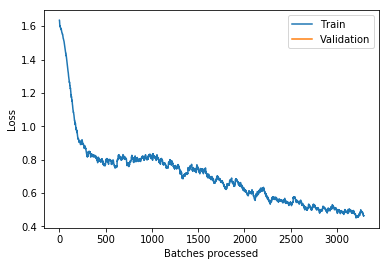

In [36]:
learn.recorder.plot_losses()

# testing

In [37]:
learn = learn.to_fp32()

In [38]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()
preds_tst = np.argmax(preds_tst, 1)

CPU times: user 12.8 s, sys: 4.27 s, total: 17 s
Wall time: 49.5 s


In [39]:
pd.Series(preds_tst.astype(int)).value_counts()

2    1202
0     363
1     152
4     112
3      99
dtype: int64

## submit

In [40]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,4
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [41]:
subm.diagnosis.value_counts()

2    1202
0     363
1     152
4     112
3      99
Name: diagnosis, dtype: int64

In [42]:
subm.to_csv(f"{p_o}/submission.csv", index=False)